In [2]:
# 匯入必要套件

import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import docplex
from docplex.mp.model import Model

In [3]:
# 定義初始參數

NOMb = 200            #標稱電池容量,單位為kWh
ESS_Ch_max = 50       #Battery max允許以kW為單位的充電功率
ESS_Disch_max = 50    #Battery max允許以kW為單位的放電功率，放電功率是正的 
SOC_Init = 0.5        #初始儲能電池SOC
SOCmin = 0.1          #電池充電狀態(最低SOC)
SOCmax =0.9           #電池充電狀態(最高SOC)
SOC_final =0.5        #儲能電池目標SOC
efficiency=0.97       #電池充放電效率都假設一樣 
MOF_efficiency = 0.98 #MOF點的效率(pcs以上上位裝置)

In [4]:
# 定義負載與電價資料

# 電力負載資料(loadprofile) 24小時(48個點)(每半小時一個點)
loadprofile=[130, 123, 116, 110, 105, 100, 105, 110, 123, 140, 159, 172, 135, 172, 168, 172, 167, 155, 150, 145, 140, 142, 140, 135,
             130, 123, 116, 110, 105, 100, 105, 110, 123, 140, 159, 172, 135, 172, 168, 172, 167, 155, 150, 145, 140, 142, 140, 135]
# 時間戳   24小時
# Index=      [000,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,11000,1200,1300,1400,1500,1600,1700,1800,1900,2000,2100,2200,2300]
# 時間電價 24小時(48個點)(每半小時一個點)
TOU_index = [1.32, 1.32, 1.32, 1.32, 1.32, 1.32, 1.32, 1.32, 2.9, 2.9, 4.67, 4.67, 2.9, 1.32, 4.67, 4.67, 4.67, 2.9, 2.9, 2.9, 2.9, 2.9, 1.32, 1,
             1.32, 1.32, 1.32, 1.32, 1.32, 1.32, 1.32, 1.32, 2.9, 2.9, 4.67, 4.67, 2.9, 1.32, 4.67, 4.67, 4.67, 2.9, 2.9, 2.9, 2.9, 2.9, 1.32, 1]


In [5]:
#問題模型選擇經濟調度優化問題 The Unit Commitment Problem (UCP)
ucpm = Model("ucp") 
loadprofile= Series(loadprofile)
nb_periods = len(loadprofile)
sche_lengh = len(loadprofile)
demand = loadprofile
# 設定設備模型
energies = ["coal", "gas", "diesel", "wind"]
df_energy = DataFrame({"co2_cost": [30, 5, 15, 0]}, index=energies)

all_units = ["diesel1"]
ucp_raw_unit_data = {
        "energy": ["diesel"],
        "initial" : [demand[0]],
        }
        
ess_index = ["ess1"]
ucp_raw_ess_data = {
        "energy": ["ess"],
        "initial" : [0],
        "max_ch": [ESS_Ch_max],
        "max_disch": [ESS_Disch_max],
        }
df_units = DataFrame(ucp_raw_unit_data, index=all_units)
ess_unit = DataFrame(ucp_raw_ess_data, index=ess_index)
df_up = pd.merge(df_units, df_energy, left_on="energy", right_index=True)
df_up.index.names=['units'] 
df_units.index.names=['df_unit'] 
ess_unit.index.names=['ess_unit']

In [6]:
# 設定決策變量(decision variables)
# 設備列表 
ess = ["ess1"]
# 時間長度 0~48 range from 1 to nb_periods included 
periods = range(0, nb_periods)
production = ucpm.continuous_var_matrix(keys1=all_units, keys2=periods, name="p")
production_variation = ucpm.continuous_var_matrix(keys1=all_units, keys2=periods, name="production_variation")

# 同一個時間只能充電或是放電 
charge_var = ucpm.binary_var_matrix(keys1=ess, keys2=periods, name="charge_var")
discharge_var = ucpm.binary_var_matrix(keys1=ess, keys2=periods, name="discharge_var")
# 儲能系統充放電功率(PCS)
ess_ch_production = ucpm.continuous_var_matrix(keys1=ess, keys2=periods, name="ess_ch_production")
ess_disch_production = ucpm.continuous_var_matrix(keys1=ess, keys2=periods, name="ess_disch_production")
# 儲能電池SOC
ess_soc = ucpm.continuous_var_matrix(keys1=ess, keys2=periods, name="ess_soc")
# 把所有的優化變數在整合成一個表格，每個基礎每個時間的優化變數  
df_decision_vars = DataFrame({'production': production,'production_variation': production_variation })
df_decision_vars_ess = DataFrame({'charge_var': charge_var,'discharge_var' : discharge_var,'ess_ch_production' : ess_ch_production ,'ess_disch_production' : ess_disch_production,'ess_soc':ess_soc})
# Set index names (增加兩個index，機組名稱與時間)
df_decision_vars.index.names=['units', 'periods']
df_decision_vars_ess.index.names=['ess_unit', 'periods']
# 把儲能系統上下功率限制 黏貼過來 
df_join_decision_vars_ess_minmax = df_decision_vars_ess.join(ess_unit[['max_ch', 'max_disch']], how='inner')
# ------------------------------------------------------------------
print("------------------------------------")
print("df_decision_vars:")
print(df_decision_vars)
print("------------------------------------")
print("df_join_decision_vars_ess_minmax:")
print(df_join_decision_vars_ess_minmax)

------------------------------------
df_decision_vars:
                   production             production_variation
units   periods                                               
diesel1 0         p_diesel1_0   production_variation_diesel1_0
        1         p_diesel1_1   production_variation_diesel1_1
        2         p_diesel1_2   production_variation_diesel1_2
        3         p_diesel1_3   production_variation_diesel1_3
        4         p_diesel1_4   production_variation_diesel1_4
        5         p_diesel1_5   production_variation_diesel1_5
        6         p_diesel1_6   production_variation_diesel1_6
        7         p_diesel1_7   production_variation_diesel1_7
        8         p_diesel1_8   production_variation_diesel1_8
        9         p_diesel1_9   production_variation_diesel1_9
        10       p_diesel1_10  production_variation_diesel1_10
        11       p_diesel1_11  production_variation_diesel1_11
        12       p_diesel1_12  production_variation_diesel1_12


In [7]:
# 設定約束條件
# 儲能充放電功率、SOC的限制，要在最大到最小之間，疊代每個列(橫)，也就是疊代每一個機組的每一個時間點
for item in df_join_decision_vars_ess_minmax.itertuples(index=False):
    ucpm += (item.ess_disch_production <= item.max_disch * item.discharge_var) #放電功率 <= 最大放電功率*放電參數(0 or 1，同時間只會充電或是放電)
    ucpm += (item.ess_disch_production >= 0)                                   #放電功率 >= 0
    ucpm += (item.ess_ch_production <= item.max_ch * item.charge_var)          #充電功率 <= 最大充電功率*充電參數(0 or 1，同時間只會充電或是放電)
    ucpm += (item.ess_ch_production >= 0)                                      #充電功率 >= 0
    ucpm += (item.ess_soc >= SOCmin)                                           #儲能電池SOC不能低於限制SOC之最小值
    ucpm += (item.ess_soc <= SOCmax)                                           #儲能電池SOC不能高於限制SOC之最大值
    ucpm += (item.charge_var + item.discharge_var <= 1 )                       #同時間只會充電或是放電 

# soc變動限制，現在的電量會等於上個時刻的電量，加上功率流動 ，而這個小時的soc則是這個小時的功率流動完之後的結果
# 對於不同的幾組設定不同的限制，以groupby來分類決策(優化)變數們(分類依據為ess_unit)，而這邊只有一個單位(機組)(ess1)，因此最外圈的for只會跑一次
# 因為 Q = 電量 (單位kwh) 且當前程式資料區間是每半小時一點，因此在列限制式時要除2，才能算出每半小時的電量流動
for ess_unit, r in df_decision_vars_ess.groupby(level='ess_unit'): 
    # 第0個時間點的電量Q = 初始電量Q(NOMB*SOC_Initial) + 第0個時間點的電量流動delta Q(Q單位為kwh)
    ucpm.add_constraint(NOMb*SOC_Init - NOMb* r.ess_soc[0]  + (r.ess_ch_production[0] * efficiency/(sche_lengh/24)) - (r.ess_disch_production[0] / efficiency/(sche_lengh/24)) == 0) #初始化 
    # 當前時間點的電量Q = 上一個時間點的電量Q  + 當前時間點(上個時間點到當前時間點)的電量流動 
    for (p_ch_curr, p_disch_curr, soc_curr, soc_next) in zip(r.ess_ch_production[1:],r.ess_disch_production[1:],r.ess_soc, r.ess_soc[1:]): #從第二個到最後一個 
        ucpm.add_constraint(NOMb*soc_curr - NOMb*soc_next + p_ch_curr * efficiency/(sche_lengh/24) - p_disch_curr / efficiency /(sche_lengh/24) == 0)
        #效率只能假設一個   
ucpm.add_constraint(ess_soc['ess1',len(loadprofile)-1] == SOC_final)

# 電力供需平衡，功率變動量計算 
for period, r in df_decision_vars.groupby(level='periods'):   
    total_demand = demand[period] #period 1 與load 1 相同
#   用來命名約束式的字串(可選的)
    ctname = "ct_meet_demand_%d" % period 
#   發電機發電功率+儲能放電功率*效率-儲能充電功率/效率
#   這邊充電效率儲的原因是充電視為增加需量，若一樣是乘以效率，這樣發電機發出的電就會減少，但事實上發電機發出的電需要多，要不然供不應求(儲能充電時)
#   所有機組的發電再加上儲能系統輸出功率 >= 負載功率需求
    ucpm.add_constraint(
        r.production[0] + 
        df_decision_vars_ess.loc['ess1',period].ess_disch_production * MOF_efficiency    -
        df_decision_vars_ess.loc['ess1',period].ess_ch_production / MOF_efficiency   == total_demand, ctname)
#   production_variation 可直接等於發電機組提供的電*時間電價，然後將production_variation設為目標函數
#   因會透過上面的限制式(所有機組的發電再加上儲能系統輸出功率>= 負載功率需求)，當儲能輸出，就不需要發電機提供全部的功率來滿足負載 -> 儲能輸出與發電機輸出相反
    ucpm.add_constraint(df_decision_vars.loc['diesel1',period].production_variation == df_decision_vars.loc['diesel1',period].production*TOU_index[period]/(sche_lengh/24))

In [8]:
# 設定目標函數 求解
# 功率大小會影響變動成本
total_variable_cost = ucpm.sum(df_decision_vars.production_variation)  
ucpm.add_kpi(total_variable_cost, "Total Variable Cost")
ucpm.minimize(total_variable_cost)
ucpm.print_information()
print('---------------------------------------')

assert ucpm.solve(), "Solve of the model fails !!!"
ucpm.report()
print('---------------------------------------')

Model: ucp
 - number of variables: 336
   - binary=96, integer=0, continuous=240
 - number of constraints: 481
   - linear=481
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
---------------------------------------
* model ucp solved with objective = 8012.939
*  KPI: Total Variable Cost = 8012.939
---------------------------------------


In [9]:
# 整合輸出並比較
df_p_diesel = df_decision_vars.production.apply(lambda v: max(0, v.solution_value)).unstack(level='units')
df_ess_disch_p =df_decision_vars_ess.ess_disch_production.apply(lambda v: max(0, v.solution_value)).unstack(level='ess_unit')
df_ess_ch_p =df_decision_vars_ess.ess_ch_production.apply(lambda v: max(0, v.solution_value)).unstack(level='ess_unit')
df_ess_soc =df_decision_vars_ess.ess_soc.apply(lambda v: max(0, v.solution_value)).unstack(level='ess_unit')
df_ess_charge_var = df_decision_vars_ess.charge_var.apply(lambda v : v.solution_value).unstack(level='ess_unit')
df_ess_discharge_var = df_decision_vars_ess.discharge_var.apply(lambda v : v.solution_value).unstack(level='ess_unit')
ess_power = df_ess_disch_p - df_ess_ch_p
final_load =demand.sub(ess_power['ess1'], fill_value=0)
p_var = [0]
for i in range(len(final_load)):
    if i>0:
        p_var.append(final_load[i]-final_load[i-1])
output = DataFrame({'original_load': demand,   #原本的負載需求
                    'ess': ess_power['ess1'], #儲能需量(充電為負，放電為正)
                    'new_load':final_load,    #加入儲能後，總需量
                    'Power_variation' :p_var, #功率變動(加入儲能後需量變動)
                    'SOC':df_ess_soc['ess1']*100,
                    'diesel_P':df_p_diesel['diesel1'],
                    'charge_var':df_ess_charge_var['ess1'],
                    'discharge_var':df_ess_discharge_var['ess1'],
                    'charge_p' : df_ess_ch_p['ess1'],
                    'discharge_p' : df_ess_disch_p['ess1'],
                    })

In [12]:
#原本成本
original_cost = 0 
for i in range(len(loadprofile)):
# 要除的原因是因為 TOU_index 裡的每個值得單位是"kwh"，但我們在算的時間間隔是半小時一點
# 元 = 元/kwh(單位電價) * 單位負載用量(半小時) * 0.5h(除2) 
    original_cost = original_cost+ loadprofile[i]*TOU_index[i]/( len(TOU_index)/24) 
ucpm.report_kpis()
print('original_cost :',original_cost)
print('---------------------------------------')
print(output)

*  KPI: Total Variable Cost = 8012.939
original_cost : 8923.980000000001
---------------------------------------
    original_load        ess    new_load  Power_variation        SOC  \
0             130   0.000000  130.000000         0.000000  50.000000   
1             123   0.000000  123.000000        -7.000000  50.000000   
2             116 -14.948454  130.948454         7.948454  53.625000   
3             110   0.000000  110.000000       -20.948454  53.625000   
4             105   0.000000  105.000000        -5.000000  53.625000   
5             100 -50.000000  150.000000        45.000000  65.750000   
6             105 -50.000000  155.000000         5.000000  77.875000   
7             110 -50.000000  160.000000         5.000000  90.000000   
8             123   0.000000  123.000000       -37.000000  90.000000   
9             140   0.000000  140.000000        17.000000  90.000000   
10            159  50.000000  109.000000       -31.000000  77.113402   
11            172  50.0

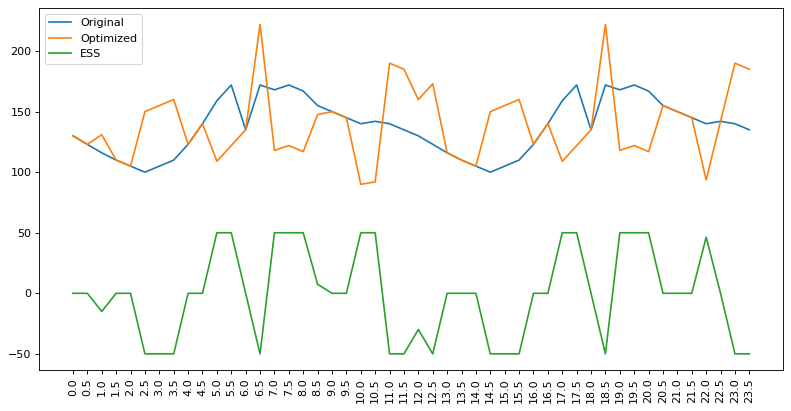

In [61]:
idx_list=list(output.index)
h_list=[i*0.5 for i in idx_list]
output['h_list']=h_list

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6), dpi=80)

default_x_ticks = h_list
plt.plot(default_x_ticks, output['original_load'], label='Original')
plt.plot(default_x_ticks, output['new_load'], label='Optimized')
plt.plot(default_x_ticks, output['ess'], label='ESS')
plt.xticks(default_x_ticks, h_list,rotation=90)
plt.legend()
plt.show()